<h1 align="center">Flight Delay Analysis</h1>


<br />

## Importing the required packages

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

<br/>

## Creating Spark Session


In [2]:
spark = SparkSession.builder\
                    .appName("FlightDelayAnalysis")\
                    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/03 16:09:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<br/>

## Loading the dataset

In [3]:
df = spark.read.csv("PATH_TO_FLIGHTS_DATA_SET", header=True, inferSchema=True)
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- DOT_ID_Marketing_Airline: integer (nullable = true)
 |-- IATA_Code_Marketing_Airline: string (nullable = true)
 |-- Flight_Number_Marketing_Airline: integer (nullable = true)
 |-- Originally_Scheduled_Code_Share_Airline: string (nullable = true)
 |-- DOT_ID_Originally_Scheduled_Code_Share_Airline: double (nullable = true)
 |-- IATA_Code_Originally_Scheduled_Code_Share_Airline: string (nullable = true)
 |-- Flight_Num_Originally_Scheduled_Code_Share_Airline: double (nullable = true)
 |-- Operating_Airline : string (nullable = true)
 |-- DOT_ID_Operating_Airline: integer (nullable = true)
 |-- IATA_Code_Operating_Air

In [10]:
airlines_df = spark.read.csv("PATH_TO_AIRLINE_DATA_SET", header=True, inferSchema=True)
airlines_df.printSchema()

root
 |-- Code: string (nullable = true)
 |-- Description: string (nullable = true)



In [4]:
safe_df = df

In [11]:
df = safe_df

<br />

## Data Preprocessing

In [5]:
# Required columns for the analysis
requiredColumns = [
    "FlightDate", "Year", "Quarter", "DayofMonth", "Month", "DayOfWeek", # Flight date details
    "Operating_Airline ", "Marketing_Airline_Network", # Airline details
    "Origin", "OriginState", "Dest", "DestState", # Airport details
    "CRSArrTime", "ArrDelayMinutes", "ArrDel15", "CRSDepTime", "DepDelayMinutes", "DepDel15", # Time details
    "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", # Delay reason details
    "Cancelled", "CancellationCode", # Cancellation details
    'AirTime', 'Distance', 'TaxiIn', 'TaxiOut' # Additional details
]

# Dropping duplicate rows
df = df.dropDuplicates()

# Keeping necessary columns and dropping others
df = df[requiredColumns]

# Renaming columns
df = df.withColumnRenamed("Operating_Airline ","OperatingAirline")
df = df.withColumnRenamed("Marketing_Airline_Network","MarketingAirline")
df = df.withColumnRenamed("CRSDepTime","ScheduledDepTime")
df = df.withColumnRenamed("CRSArrTime","ScheduledArrTime")

df.printSchema()

root
 |-- FlightDate: date (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- OperatingAirline: string (nullable = true)
 |-- MarketingAirline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestState: string (nullable = true)
 |-- ScheduledArrTime: integer (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- ArrDel15: double (nullable = true)
 |-- ScheduledDepTime: integer (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDel15: double (nullable = true)
 |-- CarrierDelay: double (nullable = true)
 |-- WeatherDelay: double (nullable = true)
 |-- NASDelay: double (nullable = true)
 |-- SecurityDelay: double (nullable = true)
 |-- LateAircraftDelay: double (nullable = true)
 |-- Ca

In [ ]:
df = df.withColumn()

<br />

## Flight Count Analysis

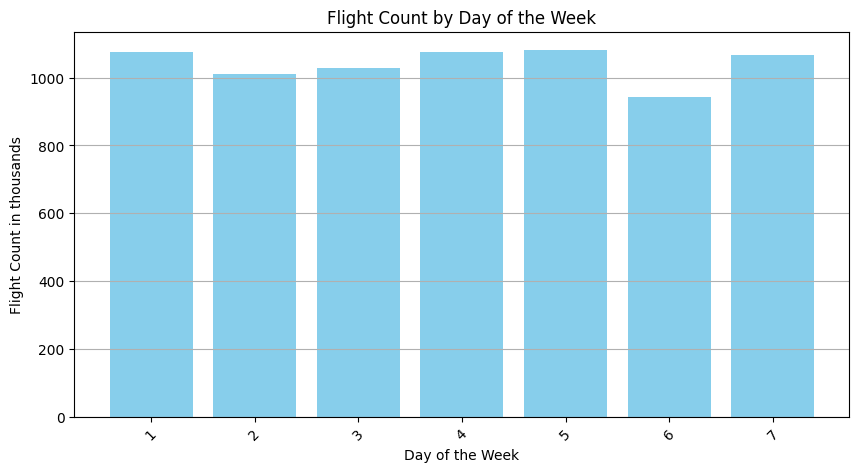

In [9]:
# Analyzing the distribution of flights over different days of the week

flightCountByDayOfWeek = df.groupBy("DayOfWeek").count().orderBy("DayOfWeek").collect()

daysOfWeek = [row["DayOfWeek"] for row in flightCountByDayOfWeek]
flightCountDay = [row["count"] / 1000 for row in flightCountByDayOfWeek]

plt.figure(figsize=(10, 5))
plt.bar(daysOfWeek, flightCountDay, color='skyblue')
plt.title('Flight Count by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Flight Count in thousands')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

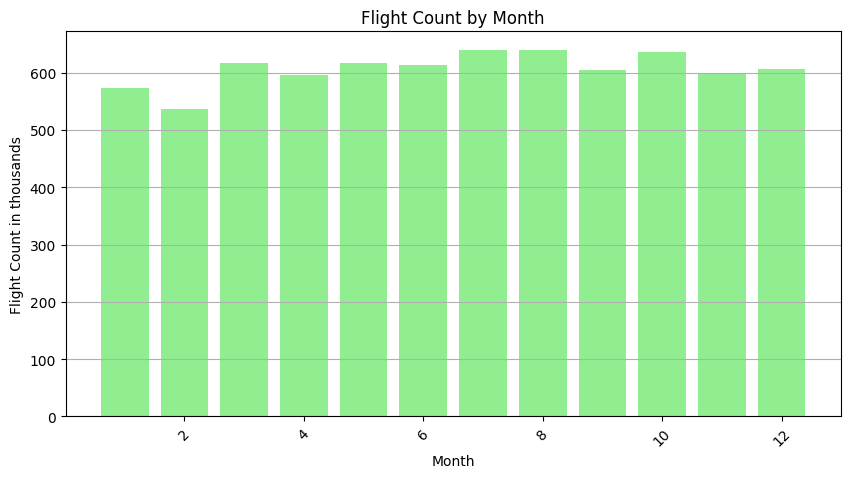

In [11]:
# Analyzing the distribution of flights over different months

flightCountByMonth = df.groupBy("Month").count().orderBy("Month").collect()

months = [row["Month"] for row in flightCountByMonth]
flightCountMonth = [row["count"] / 1000 for row in flightCountByMonth]

plt.figure(figsize=(10, 5))
plt.bar(months, flightCountMonth, color='lightgreen')
plt.title('Flight Count by Month')
plt.xlabel('Month')
plt.ylabel('Flight Count in thousands')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

<br />

## Airline Analysis

In [22]:
# Count the occurrences of flights for each airline network
airline_counts = df.groupBy("OperatingAirline").agg(F.count("*").alias("FlightCount"))

# Join with airline_info_df to get airline description
airline_counts_with_description = airline_counts.join(airlines_df, airline_counts["OperatingAirline"] == airlines_df["Code"], "left_outer") \
    .select(airline_counts["OperatingAirline"], airlines_df["Description"].alias("Airline Name"), airline_counts["FlightCount"])

# Displaying results
print("Airlines with the most flights:")
airline_counts_with_description.show(10, truncate=False)

Airlines with the most flights:


+----------------+---------------------------+-----------+
|OperatingAirline|Airline Name               |FlightCount|
+----------------+---------------------------+-----------+
|UA              |United Air Lines Inc.      |732212     |
|NK              |Spirit Air Lines           |263871     |
|AA              |American Airlines Inc.     |940531     |
|B6              |JetBlue Airways            |274852     |
|PT              |Capital Cargo International|99047      |
|DL              |Delta Air Lines Inc.       |984986     |
|OO              |SkyWest Airlines Inc.      |675285     |
|F9              |Frontier Airlines Inc.     |177542     |
|YV              |Mesa Airlines Inc.         |88679      |
|MQ              |Envoy Air                  |227505     |
+----------------+---------------------------+-----------+
only showing top 10 rows



In [24]:
# Calculate total delay time (arrival delay + departure delay) for each airline
airline_delays = df.groupBy("OperatingAirline")\
    .agg((F.sum("ArrDelayMinutes") + F.sum("DepDelayMinutes")).alias("TotalDelayMinutes"))

# Order by total delay time to find airlines with the most delays and limit to top 10
top_10_airlines = airline_delays.orderBy("TotalDelayMinutes", ascending=False).limit(10)

# Join with airline_info_df to get airline names
top_10_airlines_with_description = top_10_airlines.join(airlines_df, top_10_airlines["OperatingAirline"] == airlines_df["Code"], "left_outer") \
    .select(top_10_airlines["OperatingAirline"], airlines_df["Description"].alias("Airline Name"))

# Displaying results
print("Top 10 Airlines with the most delays:")
top_10_airlines_with_description.show(truncate=False)


Top 10 Airlines with the most delays:


+----------------+----------------------+
|OperatingAirline|Airline Name          |
+----------------+----------------------+
|AA              |American Airlines Inc.|
|WN              |Southwest Airlines Co.|
|DL              |Delta Air Lines Inc.  |
|UA              |United Air Lines Inc. |
|OO              |SkyWest Airlines Inc. |
|B6              |JetBlue Airways       |
|NK              |Spirit Air Lines      |
|F9              |Frontier Airlines Inc.|
|AS              |Alaska Airlines Inc.  |
|YX              |Republic Airlines     |
+----------------+----------------------+



In [26]:
# Calculate total number of cancellations for each airline
airline_cancellations = df.groupBy("OperatingAirline") \
    .agg(F.sum("Cancelled").alias("TotalCancellations"))

# Order by total cancellations to find airlines with the most cancellations and limit to top 10
top_10_airlines_cancellations = airline_cancellations.orderBy("TotalCancellations", ascending=False).limit(10)

# Join with airline_info_df to get airline descriptions
top_10_airlines_cancellations_with_description = top_10_airlines_cancellations\
    .join(airlines_df, top_10_airlines_cancellations["OperatingAirline"] == airlines_df["Code"], "left_outer") \
    .select(top_10_airlines_cancellations["OperatingAirline"], airlines_df["Description"].alias("Airline Name"))

# Displaying results
print("Top 10 Airlines with the most cancellations:")
top_10_airlines_cancellations_with_description.show(truncate=False)

Top 10 Airlines with the most cancellations:


+----------------+----------------------+
|OperatingAirline|Airline Name          |
+----------------+----------------------+
|WN              |Southwest Airlines Co.|
|UA              |United Air Lines Inc. |
|DL              |Delta Air Lines Inc.  |
|AA              |American Airlines Inc.|
|OO              |SkyWest Airlines Inc. |
|YX              |Republic Airlines     |
|B6              |JetBlue Airways       |
|NK              |Spirit Air Lines      |
|9E              |Endeavor Air Inc.     |
|F9              |Frontier Airlines Inc.|
+----------------+----------------------+



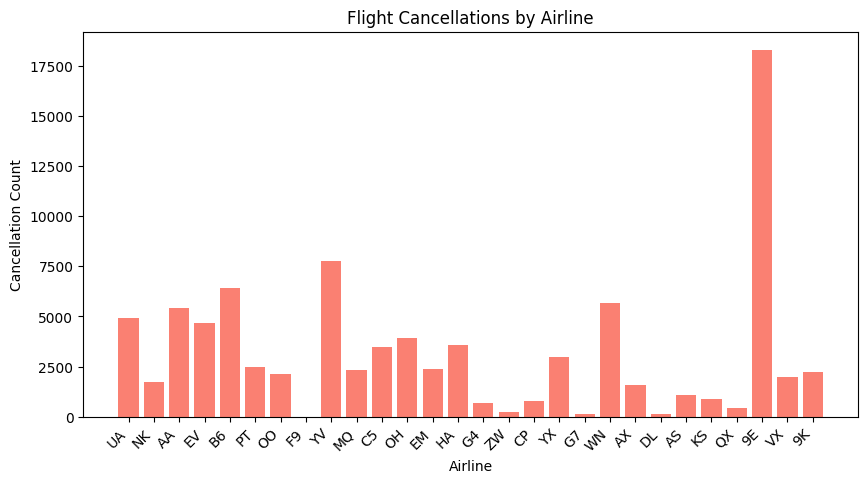

In [13]:
# Count the occurrences of flight cancellations for each airline
cancellation_counts = df.filter(F.col("Cancelled") == 1).groupBy("OperatingAirline").agg(F.count("*").alias("CancellationCount"))

# Plotting a bar chart to visualize the distribution of flight cancellations
airlines = cancellation_counts.select("OperatingAirline").rdd.flatMap(lambda x: x).collect()
cancellation_counts = cancellation_counts.select("CancellationCount").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 5))
plt.bar(airlines, cancellation_counts, color='salmon')
plt.xlabel('Airline')
plt.ylabel('Cancellation Count')
plt.title('Flight Cancellations by Airline')
plt.xticks(rotation=45, ha='right')
plt.show()

<br />

## Airport Analysis

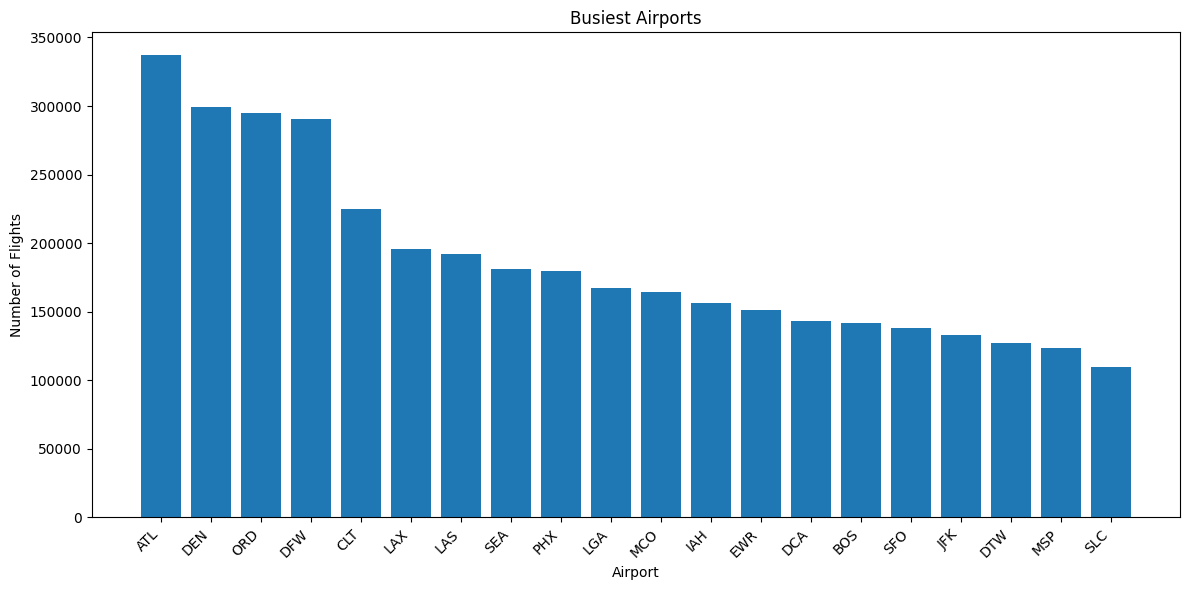

In [30]:
# Group by Origin airport and count the number of flights
busiest_airports = df.groupBy("Origin").count().orderBy("count", ascending=False)

top_10_busiest_airports = busiest_airports.orderBy("count", ascending=False).limit(20)

# Convert busiest_airports dataframe to Pandas for plotting
busiest_airports_pd = top_10_busiest_airports.toPandas()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(busiest_airports_pd['Origin'], busiest_airports_pd['count'])
plt.xlabel('Airport')
plt.ylabel('Number of Flights')
plt.title('Busiest Airports')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

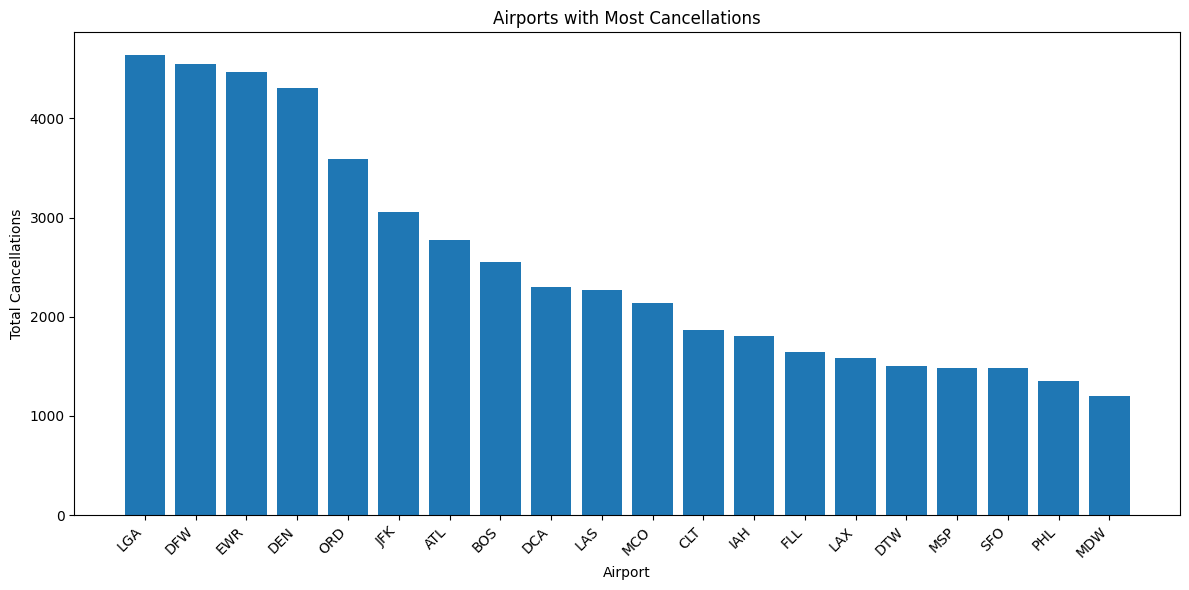

In [33]:
# Group by Origin airport and sum cancellations
most_cancellations_airports = df.groupBy("Origin").agg(F.sum("Cancelled").alias("TotalCancellations")).orderBy("TotalCancellations", ascending=False)

top_10_airports_with_cancellations = most_cancellations_airports.limit(20)

# Convert most_cancellations_airports dataframe to Pandas for plotting
most_cancellations_airports_pd = top_10_airports_with_cancellations.toPandas()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(most_cancellations_airports_pd['Origin'], most_cancellations_airports_pd['TotalCancellations'])
plt.xlabel('Airport')
plt.ylabel('Total Cancellations')
plt.title('Airports with Most Cancellations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

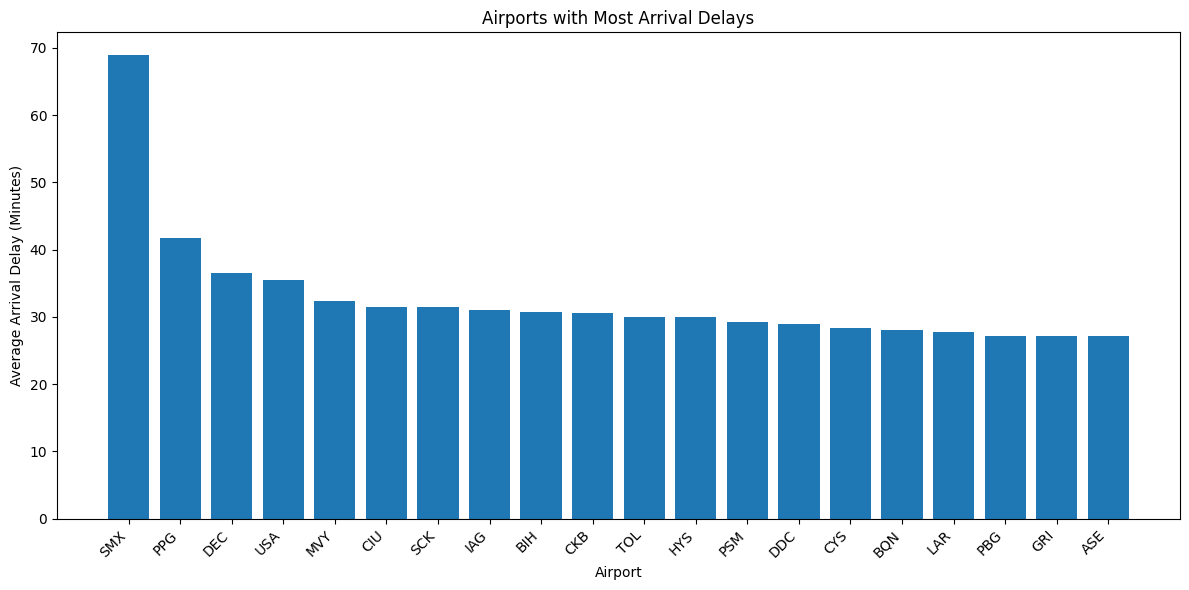

In [35]:
# Group by Origin airport and calculate average arrival delay
most_delays_airports = df.groupBy("Origin").agg(F.avg("ArrDelayMinutes").alias("AvgArrivalDelay")).orderBy("AvgArrivalDelay", ascending=False)

# Convert most_delays_airports dataframe to Pandas for plotting
most_delays_airports_pd = most_delays_airports.limit(20).toPandas()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(most_delays_airports_pd['Origin'], most_delays_airports_pd['AvgArrivalDelay'])
plt.xlabel('Airport')
plt.ylabel('Average Arrival Delay (Minutes)')
plt.title('Airports with Most Arrival Delays')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

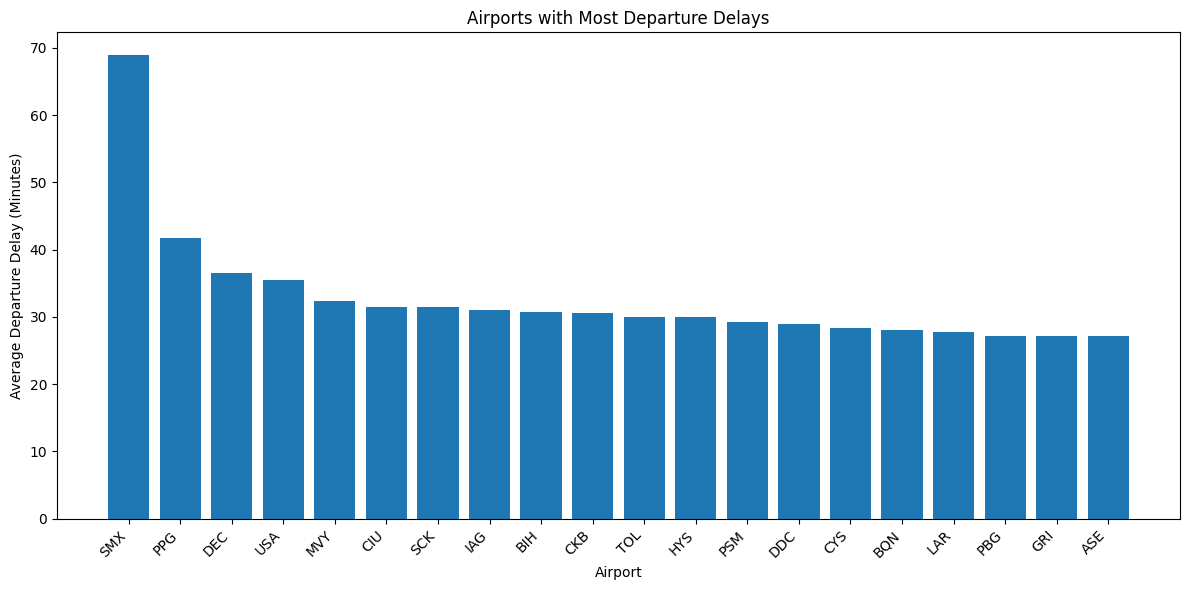

In [36]:
# Group by Origin airport and calculate departure arrival delay
most_delays_airports = df.groupBy("Origin").agg(F.avg("ArrDelayMinutes").alias("AvgArrivalDelay")).orderBy("AvgArrivalDelay", ascending=False)

# Convert most_delays_airports dataframe to Pandas for plotting
most_delays_airports_pd = most_delays_airports.limit(20).toPandas()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(most_delays_airports_pd['Origin'], most_delays_airports_pd['AvgArrivalDelay'])
plt.xlabel('Airport')
plt.ylabel('Average Departure Delay (Minutes)')
plt.title('Airports with Most Departure Delays')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<br />

## Delay Reasons Analysis

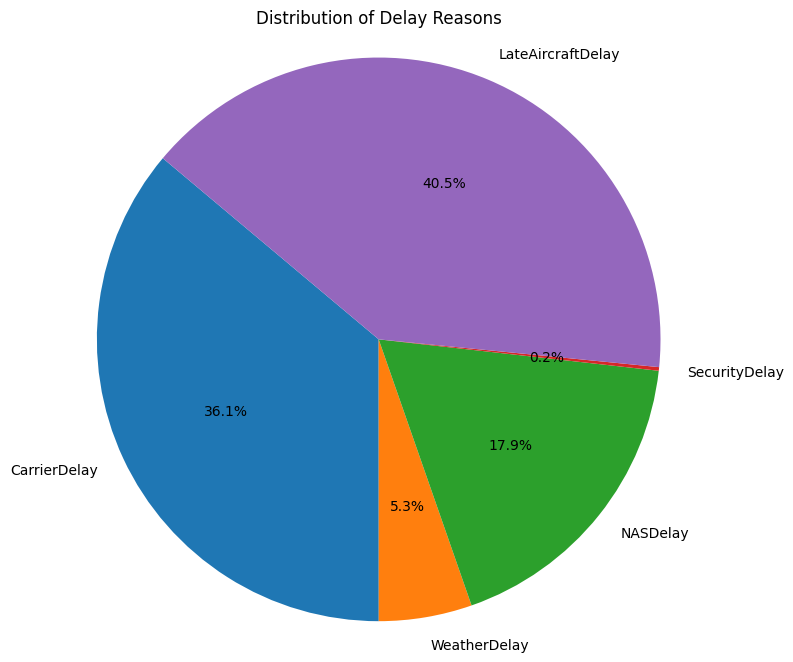

In [37]:
# Calculate the total delay time for each delay reason
delay_reasons = df.groupBy().agg(
    F.sum("CarrierDelay").alias("CarrierDelay"),
    F.sum("WeatherDelay").alias("WeatherDelay"),
    F.sum("NASDelay").alias("NASDelay"),
    F.sum("SecurityDelay").alias("SecurityDelay"),
    F.sum("LateAircraftDelay").alias("LateAircraftDelay")
)

# Convert the delay reasons DataFrame to Pandas for plotting
delay_reasons_pd = delay_reasons.toPandas()

# Plot the pie chart
labels = delay_reasons_pd.columns.tolist()
sizes = delay_reasons_pd.values.flatten()
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Delay Reasons')
plt.show()